In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import pymcr
from pymcr.mcr import McrAR
from pymcr.regressors import OLS, NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from pyDOE import lhs
import numpy as np

# Final Model : monod-logistic bacteria growth model

In [2]:
def combined_ode_system(t,y,y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1
    
    Y_xg = (0.052)* 10**0
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0    
    
    Y_mx = (20)* 10**-1
    beta = (5)* 10**-0.75
    
    kc = 10**1.5
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mu_g = 2*((mu_g_max*Cg)/(Kg + Cg))
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    mu_death = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    dXvdt = (mu_growth - mu_death)*Xv 
    
    dXddt = mu_death*Xv
    
    dCgdt = -1*(mu_growth/Y_xg)*Xv - maint_gc*Xv
    
    dCmdt = Y_mx*(mu_growth + beta)*Xv*(Cc/(Cc + kc))
    
    dCcdt = -1*dCmdt
    
    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]

In [3]:
def calc_mu_growth(y, y0_g):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_g_max = ((0.74)* 10**-0.75)
    Kg = (0.2)* 10**2
    
    Y_xg = (0.052)* 10**0
        
    mu_g = 2*(mu_g_max*Cg)/(Kg + Cg)
    
    Xm = Y_xg*y0_g
    
    log_x = (1-(Xv/Xm))
    
    mu_growth = mu_g*log_x
    
    return mu_growth

def calc_mu_death(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    mu_c_death = (0.06)* 10**0.25
    Kc = (1)* 10**1.5
    
    k_d = (0.001)* 10**1

    mu_c = k_d + ((mu_c_death*Cc)/(Kc + Cc))/2
        
    mu_death = mu_c
    
    return mu_death

def calc_cat_maint(y):
    
    Xv, Xd, Cg, Cm, Cc = y
    
    m_k = (0.06)* 10**-2
    k_c_maint = (0.03)* 10**0
    
    maint_gc = (m_k*Cc)/(k_c_maint + Cc)
    
    return maint_gc

In [4]:
y0 = np.array([0.1, 0.0, 82, 0, 20])
tspan = (0, 72)

sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau")

y_true = np.copy(sol.y)

y_act = sol.y
y_act[0,:] = y_act[0,:] + y_act[1,:]
y_act1 = np.delete(y_act, 1, axis = 0)

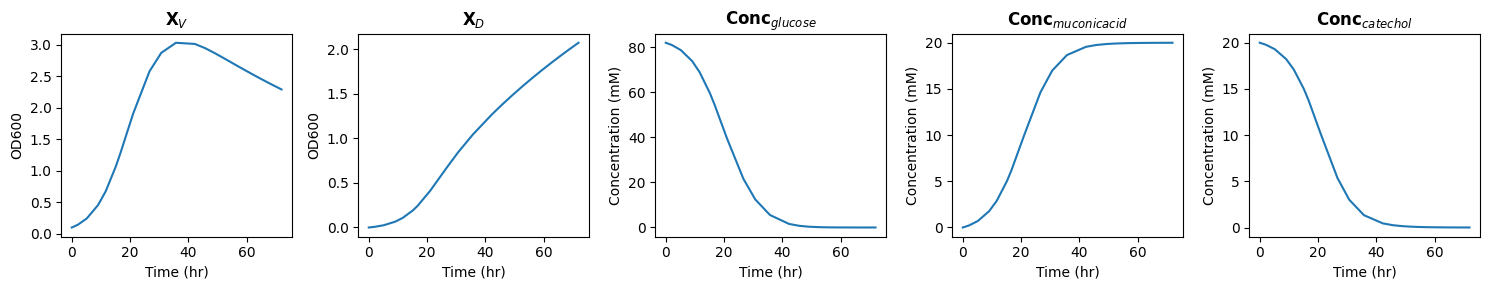

In [5]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

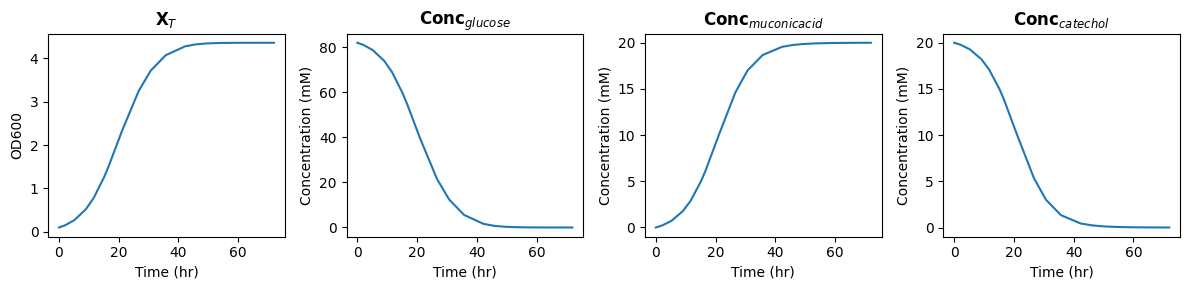

In [6]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [7]:
file_name = "Initial_conditions_3_5_PP.txt"
Init_cond = np.loadtxt(file_name)
num_rep = file_name.split("_")[3]

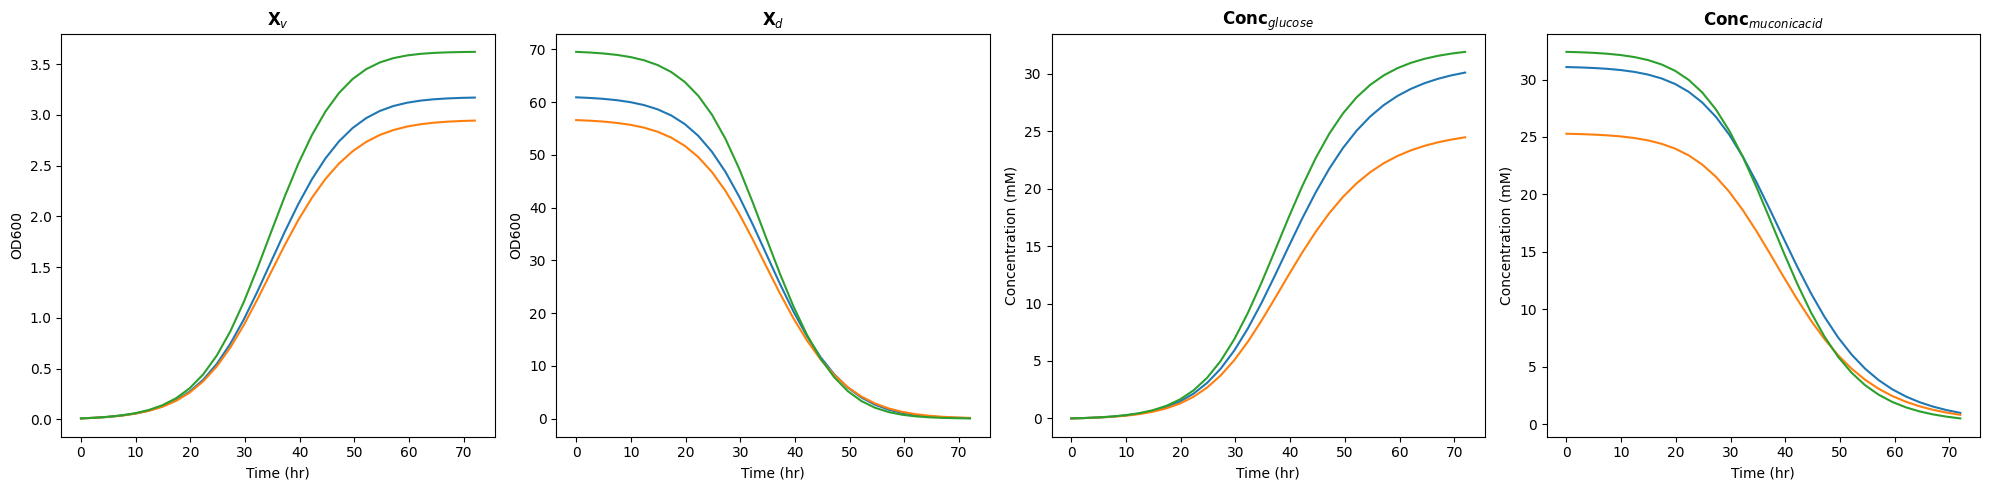

In [8]:
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
axs = axs.ravel()

sol_list = []

for i in range(len(Init_cond[:,0])):
    
    y0 = Init_cond[i,:]
    tspan = (0, 72)
    teval = np.linspace(tspan[0], tspan[1], 30)
    sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
    sol_list.append(sol)
    
    y_act = sol.y
    y_act[0,:] = y_act[0,:] + y_act[1,:]
    y_act = np.delete(y_act, 1, axis = 0)
    
    Name = ["X$_v$", "X$_d$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
    ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

    for j in range(len(y_act)):
        axs[j].plot(sol.t, y_act[j])
        axs[j].set_xlabel("Time (hr)")
        axs[j].set_ylabel(ylabels[j])
        axs[j].set_title(Name[j], fontweight = "bold")
        
plt.tight_layout()

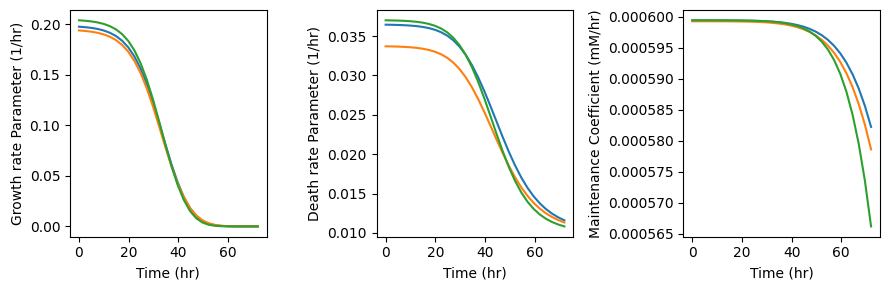

In [9]:
fig, axs = plt.subplots(1,3,figsize = (9, 3))
ax = axs.ravel()

for i in range(len(sol_list)):
    s = sol_list[i]
    ax[0].plot(s.t, calc_mu_growth(s.y, Init_cond[i,:][2]))
    ax[1].plot(s.t, calc_mu_death(s.y))
    ax[2].plot(s.t, calc_cat_maint(s.y))
        
    ax[0].set_xlabel("Time (hr)")
    ax[1].set_xlabel("Time (hr)")
    ax[2].set_xlabel("Time (hr)")
    
    ax[0].set_ylabel("Growth rate Parameter (1/hr)")
    ax[1].set_ylabel("Death rate Parameter (1/hr)")
    ax[2].set_ylabel("Maintenance Coefficient (mM/hr)")
    
plt.tight_layout()

# Data generation

In [10]:
def syn_data_generation(num_points, file_name):
    
    Init_cond = np.loadtxt(file_name)

    sol_dict = {}
    mu_dict = {}

    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i,:]
        tspan = (0, 72)
        teval = np.linspace(tspan[0], tspan[1], num_points)
        
        sol = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), method = "Radau", t_eval = teval)
        mus = calc_mu_growth(sol.y, y0[2])
        
        y_act = sol.y
        y_act[0,:] = y_act[0,:] + y_act[1,:]
        y_act = np.delete(y_act, 1, axis = 0)
        
        sol_dict[i] = y_act
        mu_dict[i] = mus
        
        time = sol.t
    
    return [time, sol_dict, mu_dict]

In [11]:
def spline_grad(y,t):
    
    num = len(y)
    fin = []
    
    for i in range(num):
        func_fit = CubicSpline(t, y[i])
        dAdt = func_fit(t,1)
        fin.append(dAdt)

    return fin

In [12]:
def Error_addition(num_points, file_name, per_err, rs):
    
    random_seed = rs
    
    time, s_dict, k_dict = syn_data_generation(num_points, file_name)    
    num_sp, num_t = np.shape(s_dict[0])

    retreived_conc_dict = {}

    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed+i)
        D_err = np.random.normal(0,per_err,size = (num_sp, num_t))/100
        
        conc_profiles = s_dict[i]
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)

        retreived_conc_dict[i] = D_final

    
    return [time, retreived_conc_dict]

In [13]:
time, s, m = syn_data_generation(10, file_name)
t, rc = Error_addition(10, file_name, 10, rs = 20)

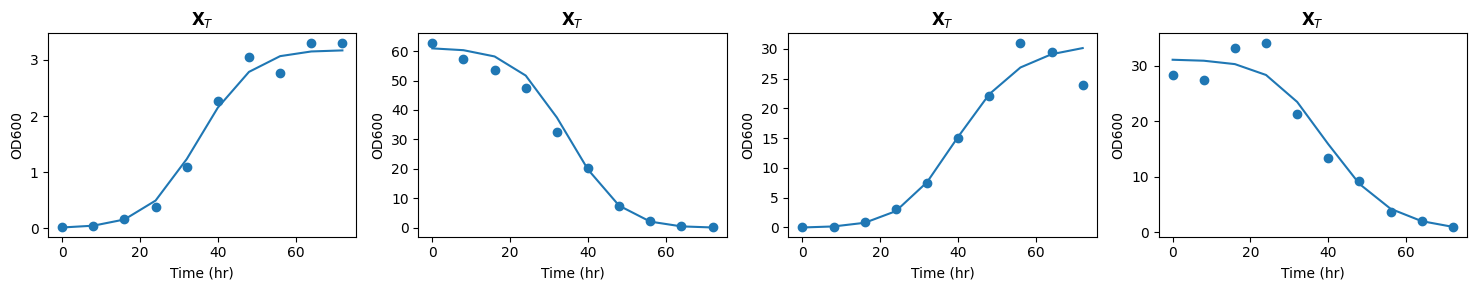

In [14]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (15,3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)")
    ax[j].set_ylabel(ylabels[i])
    ax[j].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

# Model construction

In [15]:
def make_model_rs_fl(rs1, fl):
    
    num = 10
    err = 10
    rs = rs1

    time, s, k = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    y_temp = []

    for i in range(len(s)):
        y_temp.append(rc[i])

    y_temp = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(y_temp)

    t = no_touch_t

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    X = []
    y = []

    for i in range(n_d):
        for j in range(n_t):
            tempX = np.append(y_temp[i,:,0], t[j])
            tempy = y_temp[i,:,j]

            X.append(tempX)
            y.append(tempy)

    X = np.array(X)
    y = np.array(y)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

    SS_x = StandardScaler()
    SS_y = StandardScaler()

    X_train_scaled = SS_x.fit_transform(X_train)
    X_test_scaled = SS_x.transform(X_test)

    y_train_scaled = SS_y.fit_transform(y_train)
    y_test_scaled = SS_y.transform(y_test)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    mlp = MLPRegressor(early_stopping = True,
                              max_iter = 10000,
                              random_state = 42, 
                              shuffle = True,
                              validation_fraction = 0.2)
    hls = []
    numnodes = [5, 10, 15, 20, 30, 35, 40]

    for i in numnodes:
        hls.append(tuple([i]))
        for j in numnodes:
            hls.append(tuple([i,j]))
#             for k in numnodes:
#                 hls.append(tuple([i,j,k]))


    param_grid = {
        "hidden_layer_sizes" : hls,
        "activation" : ["tanh", "logistic"],
        "alpha" : np.logspace(-5, -2, 5)
    }
    
    grid_search = GridSearchCV(mlp, 
                           param_grid,
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score = True
                          )
    grid_search.fit(X_train_scaled, y_train_scaled)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    best_estimator = grid_search.best_estimator_
    
    SS_x = StandardScaler()
    SS_y = StandardScaler()

    X_scaled = SS_x.fit_transform(X)

    y_scaled = SS_y.fit_transform(y)

    best_estimator.fit(X_scaled, y_scaled)
    
    return [SS_x, SS_y, best_estimator]

# Model assembly and testing

In [16]:
def BB_ODE(x, SS_x, SS_y, ANN):
    
    tempx_scaled = SS_x.transform(x.reshape(1,-1))
    
    y_predict_scaled = ANN.predict(tempx_scaled)
    
    y_predict = SS_y.inverse_transform(y_predict_scaled)
    
    return y_predict

In [17]:
def BB_Org_model_comparison_time(y0, SS_x, SS_y, ANN): 
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)


    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args = tuple([y0[2]]), 
                           method = "Radau", t_eval = np.linspace(tspan[0],tspan[1],60))
    y_actual = sol_actual.y
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y_predict = []
    for i in sol_actual.t:
        X = np.append(y0_4, i)
        y_predict.append(BB_ODE(X, SS_x, SS_y, ANN))
    y_predict = np.array(y_predict).T.reshape(4,len(sol_actual.t))

    r2_list = [] #r2_score(y_actual, y_predict)#[]

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [18]:
def BB_Org_model_comparison_FB(y0, SS_x, SS_y, ANN): 
    y0 = y0
    y0_4 = np.delete(y0,1)
    tspan = (0, 200)

    sol_list = []
    t_init = 0
    t_fin = 25
    count = 0

    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args = tuple([82+10*count]), 
                           method = "Radau", t_eval = np.linspace(t_init,t_fin,10))

        sol_list.append(sol_actual)

        y0 = np.copy(sol_actual.y[:,-1])
        y0[2] += 10
        y0[-1] += 3

        t_init += 25
        t_fin += 25

    y = np.zeros((5,80))
    t = []
    for i in range(len(sol_list)):
        s = 10*i
        e = 10*(i+1)
        y[:,s:e] = sol_list[i].y
        t.append(sol_list[i].t)
    t_actual = np.array(t).reshape(-1,)

    y_actual = np.copy(y)
    y_actual[0,:] = y_actual[0,:] + y_actual[1,:]
    y_actual = np.delete(y_actual, 1, axis = 0)

    y_predict = np.zeros((4,80))
    
    for i in range(len(sol_list)):
        y_pr = []
        for j in sol_list[0].t:
            X = np.append(y0_4, j)
            y_pr.append(BB_ODE(X, SS_x, SS_y, ANN))
        y_pr = np.array(y_pr).T.reshape(4, len(sol_list[0].t))
        
        y_predict[:, 10*i:10*(i+1)] = np.copy(y_pr)
        
        y0_4 = np.copy(y_pr[:,-1])
        y0_4[1] += 10
        y0_4[-1] += 3
        

    r2_list = []

    for j in range(4):
        r2_list.append(r2_score(y_actual[j,:], y_predict[j,:]))

    return np.mean(r2_list)

In [19]:
Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [20]:
random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            SS_x, SS_y, ANN = make_model_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            SS_x, SS_y, ANN = make_model_rs_fl(random_seed_list[rs]+1, file_list[fl])

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(BB_Org_model_comparison_time(rect1_cg_cc[i], SS_x, SS_y, ANN))
            rect_FB_EX.append(BB_Org_model_comparison_FB(rect1_cg_cc[i], SS_x, SS_y, ANN))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting 5 folds for each of 560 candidates, totalling 2800 fits
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitt

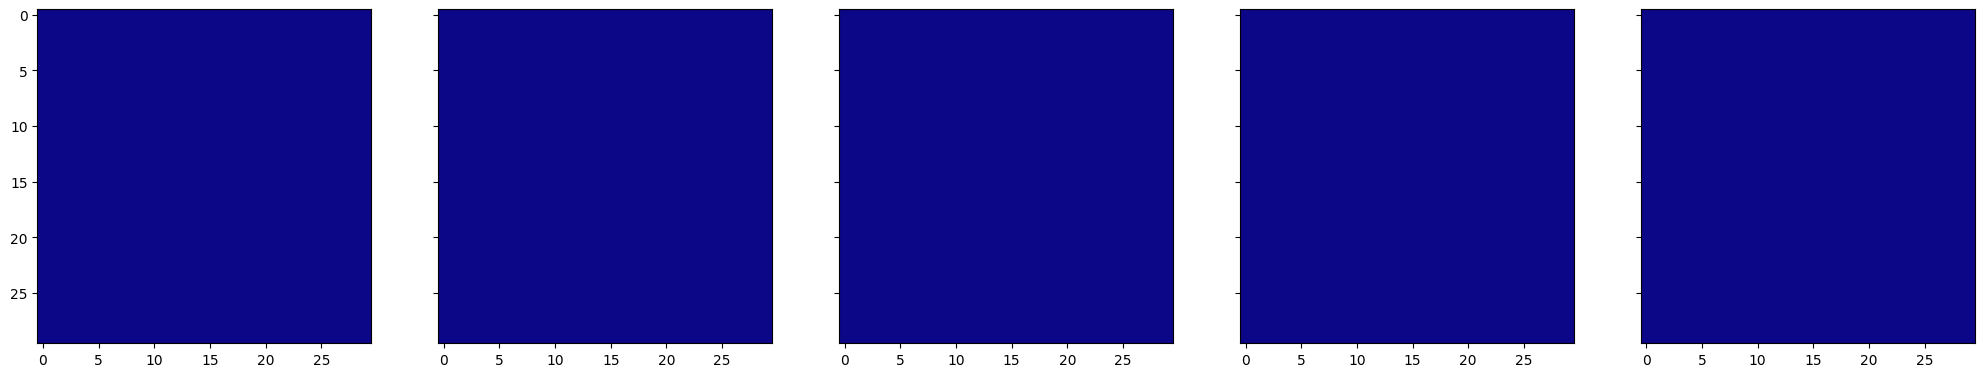

In [26]:
tempa = performance_dict["Initial_conditions_3_5_PP.txt"]

fig, axs = plt.subplots(1,5, figsize = (25,5), sharex = True, sharey = True)
ax = axs.ravel()

for i in range(5):
    pmat = np.flipud(np.array(tempa[random_seed_list[i]][1]).reshape(30,30))
    
    ax[i].imshow(pmat, vmin = 0, vmax = 1, cmap = "plasma")

In [27]:
T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

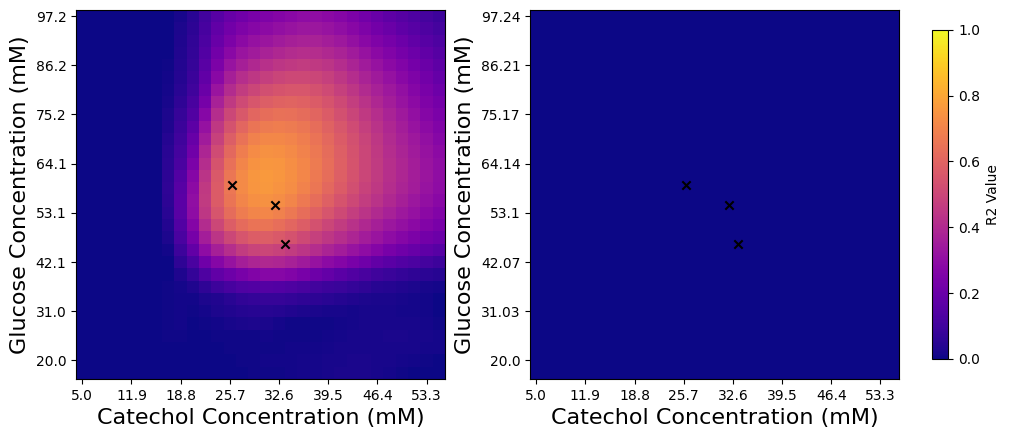

In [35]:
# Generate some example data for the heatmaps
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

x_cord = (30/50)*(Init_cond[:,-1] - 5)
y_cord = (30/80)*(Init_cond[:,2] - 20)

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].scatter(x_cord, y_cord, marker = "x", c = "k")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].scatter(x_cord, y_cord, marker = "x", c = "k")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [36]:
final_dict = {"Extrapolation" : np.array([T_EX, FB_EX])}

In [37]:
import numpy as np
import os

# Ensure the results_directory exists
file_path = "MLM_3_fl.npz" # add .npz pls check if the filename is acceptable
# Save the data as a .npz file in the sub-directory

np.savez(file_path, **final_dict)

print(f'Data saved at {file_path}')

Data saved at MLM_3_fl.npz
